In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.util import random_noise


In [12]:
class dataReader():
    def __init__(self,data):
        print ("Initializing Data Reader")
        self.scale=data["scale"]
        self.batchSize=data["batchSize"]
        self.epoch=0
        self.start=0
        self.end=self.batchSize
        self.test_epoch=0
        self.test_start=0
        self.test_end=self.batchSize
        self.train_depth,self.train_rgb=[],[]
        self.test_depth,self.test_rgb =[],[]
        self.autoencoder_train_input,self.autoencoder_train_output = [],[]
        self.autoencoder_test_input,self.autoencoder_test_output = [],[]
        self.loadTrain(data["train_file"])
        self.loadAutoencoderTrain(data["autoencoder_train_file"])
        self.loadTest(data["test_file"])
        self.loadAutoencoderTest(data["autoencoder_test_file"])
        self.imgWidth=data["imageWidth"]
        self.imgHeight=data["imageHeight"]
        self.imgChannels=data["channels"]
        self.corruptionLevel = data["corruptionLevel"]
        self.dataLength = len(self.train_depth)
        if data["colorSpace"] == "BGR":
            self.colorSpace = None
            self.colorSpaceRevert = None
            
        if data["colorSpace"] == "RGB":
            self.colorSpace = cv2.COLOR_BGR2RGB
            self.colorSpaceRevert = cv2.COLOR_RGB2BGR
        elif data["colorSpace"]== "HSV":
            self.colorSpace = cv2.COLOR_BGR2HSV
            self.colorSpaceRevert = cv2.COLOR_HSV2BGR
        elif data["colorSpace"]== "LUV":
            self.colorSpace = cv2.COLOR_BGR2LUV
            self.colorSpaceRevert = cv2.COLOR_LUV2BGR
        elif data["colorSpace"]== "LAB":
            self.colorSpace = cv2.COLOR_BGR2LAB
            self.colorSpaceRevert = cv2.COLOR_LAB2BGR
        elif data["colorSpace"]== "LAB":
            self.colorSpace = cv2.COLOR_BGR2LAB
            self.colorSpaceRevert = cv2.COLOR_LAB2BGR
        elif data["colorSpace"]== "YCrCb":
            self.colorSpace = cv2.COLOR_BGR2YCrCb
            self.colorSpaceRevert = cv2.COLOR_YCrCb2BGR
        elif data["colorSpace"]== "HLS":
            self.colorSpace = cv2.COLOR_BGR2HLS
            self.colorSpaceRevert = cv2.COLOR_HLS2BGR
        elif data["colorSpace"]== "XYZ":
            self.colorSpace = cv2.COLOR_BGR2XYZ
            self.colorSpaceRevert = cv2.COLOR_XYZ2BGR
        elif data["colorSpace"]== "YUV":
            self.colorSpace = cv2.COLOR_BGR2YUV
            self.colorSpaceRevert = cv2.COLOR_YUV2BGR
            
        assert len(self.train_depth)==len(self.train_rgb),"Inconsistent length of training input and output"
        assert len(self.test_depth) == len(self.test_rgb),"Inconsistent length of testing input and output"
        print ("Train files {}".format(len(self.train_depth)))
        print ("Test  files {}".format(len(self.test_depth)))
        print ("Initialization Complete")

    def loadTrain(self,train_f):
        with open(train_f,'r') as fh:
            for i in fh:
                data=i.split(',')
                self.train_depth.append(data[0])
                self.train_rgb.append(data[1][:-1]) # exclude the final \n
    def loadAutoencoderTrain(self,train_f):
        with open(train_f,'r') as fh:
            for i in fh:
                data=i.split(',')
                self.autoencoder_train_input.append(data[0])
                self.autoencoder_train_output.append(data[1][:-1]) # exclude the final \n
                
    def loadTest(self,test_f):
        with open(test_f,'r') as fh :
            for i in fh:
                data=i.split(',')
                self.test_depth.append(data[0])
                self.test_rgb.append(data[1][:-1]) # exclude the final \n
    
    def loadAutoencoderTest(self,test_f):
        with open(test_f,'r') as fh :
            for i in fh:
                data=i.split(',')
                self.autoencoder_test_input.append(data[0])
                self.autoencoder_test_output.append(data[1][:-1]) # exclude the final \n

    def loadImages(self,imgs):
        img_list=[]
        for i in imgs:
            img=cv2.imread(i)
#             img=cv2.resize(img,(self.imgWidth,self.imgHeight))     
#             if colorConversion:
#                 img=cv2.cvtColor(img,self.colorSpace)
#             if corruption == True :
#                 #t1 = time.time()
#                 img = self.salt_pepper(img/255.)
#                 #img = random_noise(img/255.0,mode='s&p',amount= self.corruptionLevel)
#                 #print (time.time() - t1 )
#                 #s
#                 img = np.uint8(img*255.)
            
            if not img is None:
                img_list.append(img)
            else: 
                continue
        img_list = self.preProcessImages(img_list)
        return img_list
    
    def postProcessImages(self,images):
        if self.colorSpaceRevert is None :
            return images
        list_images = [cv2.cvtColor(np.uint8(img),self.colorSpaceRevert) for img in images]
        return list_images
    
    def preProcessImages(self,img_list):
        #img_list=[np.float32(i/255.0) for i in img_list]
        img_list=np.asarray(img_list)
        img_list=np.float32(img_list.reshape(-1,self.imgHeight,self.imgWidth,self.imgChannels))
        return img_list
        
    def nextTrainBatch(self,corruptionFlag):
        #print (self.train_rgb[self.start:self.end])
        inp=self.train_depth[self.start:self.end]
        gt=self.train_rgb[self.start:self.end]
        inp=self.loadImages(inp,False, False)
        gt=self.loadImages(gt,True,corruptionFlag)
        self.start=self.end
        self.end+=self.batchSize
        if self.end >= len(self.train_depth):
            self.epoch+=1
            print("************** Training data : EPOCH {} COMPLETED************\n\n".format(self.epoch))
            self.start=0
            self.end=self.batchSize
            self.train_depth,self.train_rgb=shuffle(self.train_depth,self.train_rgb)
        return (inp,gt)
    
    def nextAutoencoderTrainBatch(self):
        
        inp=self.autoencoder_train_input[self.start:self.end]
        gt=self.autoencoder_train_output[self.start:self.end]
        
        inp=self.loadImages(inp)
        gt=self.loadImages(gt)
       
        self.start=self.end
        self.end+=self.batchSize
        if self.end >= len(self.train_depth):
            self.epoch+=1
            print("************** Training data : EPOCH {} COMPLETED************\n\n".format(self.epoch))
            self.start=0
            self.end=self.batchSize
            self.autoencoder_train_input,self.autoencoder_train_output=shuffle(self.autoencoder_train_input,self.autoencoder_train_output)    
        return (inp,gt)
    
    def resetTrainBatch(self):
        self.epoch = 0
        self.start = 0
        self.end   = self.batchSize
        print("Train batch handlers reset")
        
    def resetTestBatch(self):
        self.test_epoch=0
        self.test_start=0
        self.test_end=self.batchSize
        print ("Test batch handlers reset")
        
    def nextTestBatch(self,corruptionFlag):
        print (self.test_rgb[self.test_start:self.test_end])
        inp=self.test_depth[self.test_start:self.test_end]
        gt=self.test_rgb[self.test_start:self.test_end]
        inp=self.loadImages(inp,False,False)
        gt=self.loadImages(gt,True,corruptionFlag)
        self.test_start=self.test_end
        self.test_end+=self.batchSize
        if self.test_end >= len(self.test_depth):
            self.test_epoch+=1
            print("*************Testing data : EPOCH {} COMPLETED ************ \n\n".format(self.test_epoch))
            self.test_start=0
            self.test_end=self.batchSize
            self.test_depth,self.test_rgb = shuffle(self.test_depth,self.test_rgb)
        return (inp,gt)
    def salt_pepper (self,image):
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = self.corruptionLevel
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    
    def nextAutoencoderTestBatch(self):
        inp=self.autoencoder_test_input[self.test_start:self.test_end]
        gt=self.autoencoder_test_output[self.test_start:self.test_end]
        inp=self.loadImages(inp)
        gt=self.loadImages(gt)
        self.test_start=self.test_end
        self.test_end+=self.batchSize
        if self.test_end >= len(self.test_depth):
            self.test_epoch+=1
            print("*************Testing data : EPOCH {} COMPLETED ************ \n\n".format(self.test_epoch))
            self.test_start=0
            self.test_end=self.batchSize
            self.autoencoder_test_input,self.autoencoder_test_output = shuffle(self.autoencoder_test_input,self.autoencoder_test_output)    
        return (inp,gt)
    
    def vizRandom(self): #Randomly visualize data in training and testing datasets
        ind=np.random.randint(0,len(self.test_depth))
        train_in=cv2.imread(self.train_depth[ind])
        train_in=cv2.cvtColor(train_in,cv2.COLOR_BGR2RGB)
        train_out=cv2.imread(self.train_rgb[ind])
        train_out=cv2.cvtColor(train_out,cv2.COLOR_BGR2RGB)
        test_in=cv2.imread(self.test_depth[ind])
        test_in=cv2.cvtColor(test_in,cv2.COLOR_BGR2RGB)
        test_out=cv2.imread(self.test_rgb[ind])
        test_out=cv2.cvtColor(test_out,cv2.COLOR_BGR2RGB)
        f,ax=plt.subplots(2,2)
        ax[0][0].set_title("Train Input")
        ax[0][0].imshow(train_in)
        ax[0][1].set_title("Train Output")
        ax[0][1].imshow(train_out)
        ax[1][0].set_title("Test Input")
        ax[1][0].imshow(test_in)
        ax[1][1].set_title("Test Output")
        ax[1][1].imshow(test_out)


Initializing Data Reader
Train files 108256
Test  files 27064
Initialization Complete
Time  0.44615888595581055


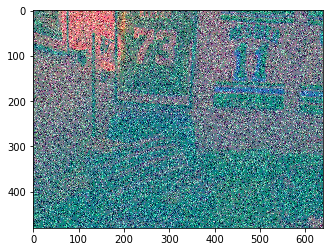

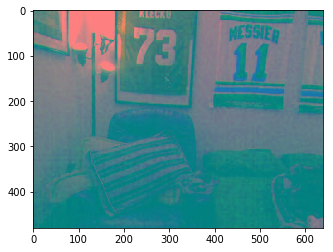

In [16]:
import time
if __name__ == '__main__':
    data = {"scale":1,"batchSize":24,"train_file" : "/home/kgunase3/data/NYUD/RAW/train.txt",
            "test_file" : '/home/kgunase3/data/NYUD/RAW/test.txt',"autoencoder_train_file" : "/home/kgunase3/data/NYUD/RAW/Autoencoder_train.txt",  
             "autoencoder_test_file" : "/home/kgunase3/data/NYUD/RAW/Autoencoder_test.txt", "colorSpace":"YUV", 
            "imageWidth" : 640,"imageHeight" :480, "channels":3,"corruptionLevel" : 0.2}
    dataObj = dataReader(data)
    t1 = time.time()
    inp,gt = dataObj.nextAutoencoderTrainBatch(corruptionFlag = True)
    print ("Time ",time.time() - t1)
    #inp,gt = dataObj.nextTestBatch(corruptionFlag = True)
    #inp1,gt1 = dataObj.nextTrainBatch(corruptionFlag= True)
    #print (gt1.shape)

    ind= 1
    import matplotlib.pyplot as plt
    plt.imshow(np.uint8(inp[ind]))
    plt.figure()
    plt.imshow(np.uint8(gt[ind]))
    